Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 2, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

In [4]:
df = pd.read_csv(data_dir+"population_data.csv"
                )

In [5]:
df

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13
5,1855,68,36
6,1857,83,15
7,1859,12,12
8,1861,36,6
9,1863,150,6


### Question 1. Find best fit nonlinear, dynamical systems model to the data using sparse regression
nonlinear = not linear  
best = lowest error, highest accuracy  
sparse = fewest model terms, (L1 regularization)  

### SVD and DMD two ways

In [6]:
# From scratch with the hare population over time
arr=df.values
X=arr[:-1, :]
Xprime=arr[1:, :]

# Compute directly with observations because there are only 30
A = Xprime @ np.linalg.pinv(X)

print(A.shape)

(29, 29)


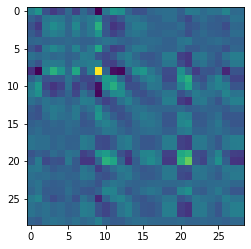

In [7]:
plt.imshow(A)

(29, 29) (29,) (29, 29)


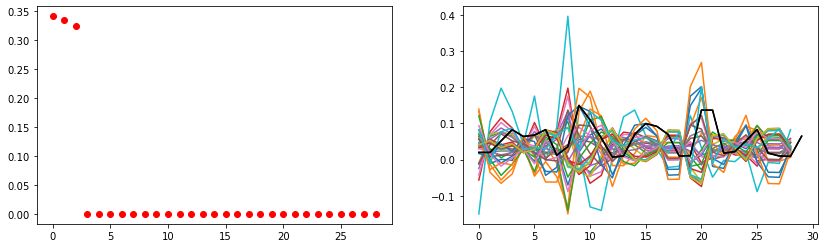

In [9]:
# Using SVD
u, s, v = np.linalg.svd(A)
print(u.shape, s.shape, v.shape)

# eigenvectors of AhA = rows of v
# eigenvectors of AAh = cols of u

# eigenvalues = s**2
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");

ax[1].plot(A);
(df.Hare/1000).plot(c="k", ax=ax[1])

ax[1].plot(np.diag(A));
(df.Hare/1000).plot(c="k")

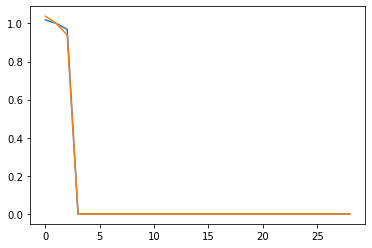

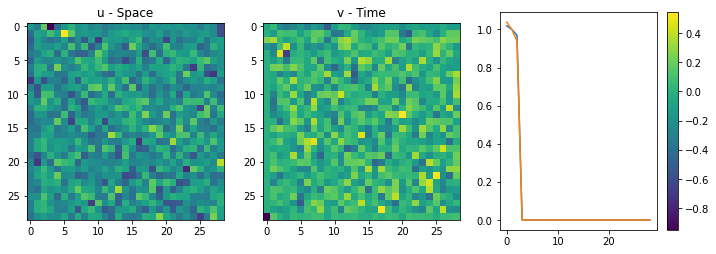

In [12]:
# Plot "space" and time components
fig, ax=plt.subplots(1, 3, figsize=(12, 4))
space=ax[0].imshow(u);
ax[0].set_title("u - Space")
time=ax[1].imshow(v);
ax[1].set_title("v - Time");
fig.colorbar(time);
ax[2].plot(s);
ax[2].plot(s**2)

Eigenvalue (1.0010684005222015+0j): distance from unit circle 0.0021379425240788397
Eigenvalue (0.3066130338669497+0.4369281091986077j): distance from unit circle 0.7150822748550343
Eigenvalue (0.3066130338669497-0.4369281091986077j): distance from unit circle 0.7150822748550343


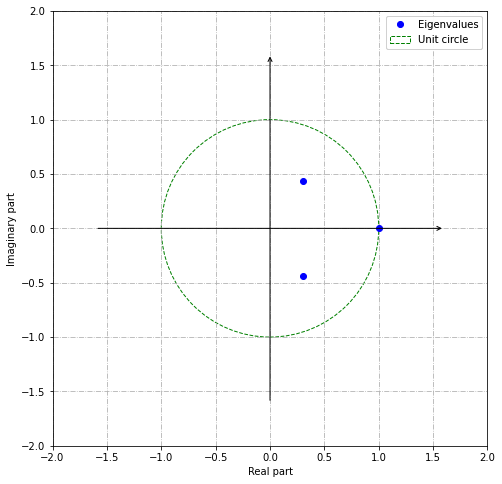

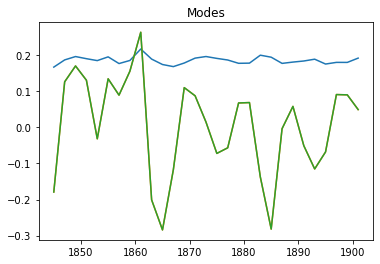

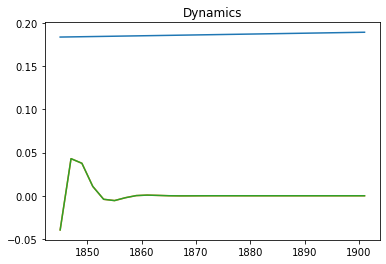

In [13]:
# Using DMD package
from pydmd import DMD
dmd = DMD(svd_rank=3)
dmd.fit(A)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

for mode in dmd.modes.T:
    plt.plot(df.Year.values[:-1], mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(df.Year.values[:-1], dynamic.real)
    plt.title('Dynamics')
plt.show()

In [14]:
# compare eigenvalues?
print("SVD:", s[:3]**2)
print("DMD:", dmd.eigs.real)
print("Difference:",  s[:3]**2 - dmd.eigs.real)

SVD: [1.03799754 1.         0.93926022]
DMD: [1.0010684  0.30661303 0.30661303]
Difference: [0.03692914 0.69338697 0.63264718]


In [15]:
# DMD function from book
def DMD(X,Xprime,r):
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

In [16]:
Phi, Lambda, b = DMD(X.T,Xprime.T,3)

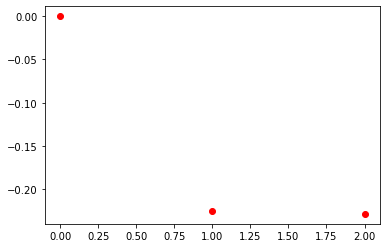

In [17]:
V2 = np.copy(np.real(Phi[:,1]))
V2=V2.T
minval = np.min(V2)
maxval = np.max(V2)

plt.plot(V2, "ro")

Eigenvalue (0.9904953470777571+0.1375462373797003j): distance from unit circle 6.661338147750939e-16
Eigenvalue (0.9935834726096825+0.11310120669950192j): distance from unit circle 7.771561172376096e-16


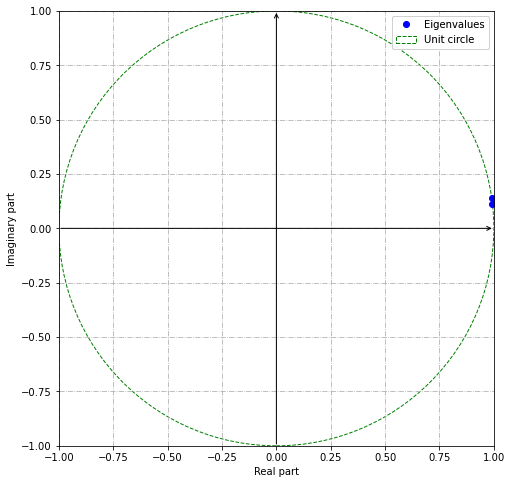

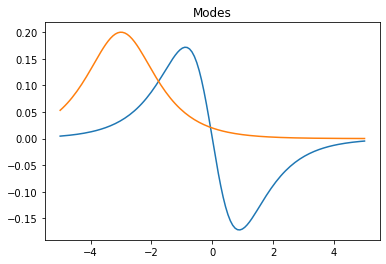

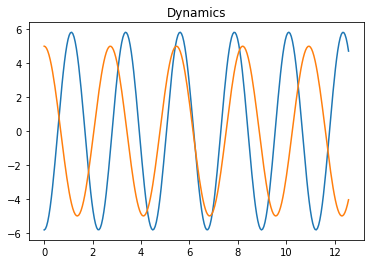

In [18]:
# Package DMD tutorial example
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

x = np.linspace(-5, 5, 128)
t = np.linspace(0, 4*np.pi, 256)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2


from pydmd import DMD
dmd = DMD(svd_rank=2)
dmd.fit(X.T)

for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

### Using SINDY

DMD the combined hare and lynx (sinusoidal model)  
2 first order differential equations like SINDY below

#### [SINDY](https://arxiv.org/pdf/1605.06682.pdf) *automatically* balances sparsity with model accuracy

authors said that SINDY + control worked better and SINDY alone  
dx/dt = f(x, u)

Lotka-Volterra Predator-Prey Model  
dx1/dt = ax1 - bx1x2 + u^2  
dx2/dt = -cx2 + dx1x2  
with x1 = hare population  
and x2 = lynx population

authros used u(t) = 2sin(t) + 2sin(t/10)  
using 100 timesteps (t) for training and 100 time steps (t) for validation

In [ ]:
# You're measuring x (x1 = hares, x2 = lynx)
# Maybe you're measuring the wrong variables, what about unknown variables y and z, (etc.)?

# x = first column
# y = second column
# z = third column

### Question 2. Compute KL divergence of the best model fit to the data
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)

KL(f,g) = integral [ f(X,Beta) * log (f(X, Beta)/g(X, mu)) dX ]

[wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)  
[scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html)  
see [mlm notes](https://machinelearningmastery.com/divergence-between-probability-distributions/) for discussion on kl_div() and rel_entr()  

### Question 3. Calculate AIC BIC scores for three of the best fit models

### Question 4. Time-delay embed the system and determine if latent variables exist

In [ ]:
# You're measuring x (x1 = hares, x2 = lynx)
# Maybe you're measuring the wrong variables, what about unknown variables y and z, (etc.)?

# x = first column
# y = second column
# z = third column
arr=df.values
x1=arr[:,1]

from scipy.linalg import hankel
# Shift matrix, construct Hankel matrix
H = hankel(x1)

# Take SVD of H
u, s, v = np.linalg.svd(H)
print(u.shape, s.shape, v.shape)

print(H.shape)

plt.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");

# Probably need a longer timeseries...

---
## Part 2 - Belousov-Zhabotinsky data

### Question 1. Download data

In [ ]:
# courses.washington.edu/amath582/BZ.mat

### Question 2. Repeat questions 1 and 2 from Part 1 using this data.

### Question 1. Find best fit nonlinear, dynamical systems model to the data using sparse regression
nonlinear = not linear  
best = lowest error, highest accuracy  
sparse = fewest model terms, (L1 regularization)  

### Question 2. Compute KL divergence of the best model fit to the data
KL divergence = statistical metrix representing info lost when g(x) is used to represent f(x)